In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from fastai.data.all import *
from fastai.vision.all import *
import PIL
from PIL import Image
from pathlib import Path
import os
from fastprogress.fastprogress import master_bar, progress_bar
from glob import glob

In [ ]:
!wget https://github.com/dizys/nyu-cv-final-project/releases/download/dataset/NYU_CV_RVAP_dataset_1.0.0.zip
!mkdir -p /content/dataset/stable_diffusion
!unzip -qq NYU_CV_RVAP_dataset_1.0.0.zip -d /content/dataset/stable_diffusion

In [ ]:
!wget https://github.com/dizys/nyu-cv-final-project/releases/download/dataset/NYU_CV_RVAP_weather_dataset_1.0.0.zip
!mkdir -p /content/dataset/weather
!unzip -qq NYU_CV_RVAP_weather_dataset_1.0.0.zip -d /content/dataset/weather

In [ ]:
def label_func(fpath: Path):
  label = "original" if "original/" in str(fpath.absolute()) else "ai"
  return label

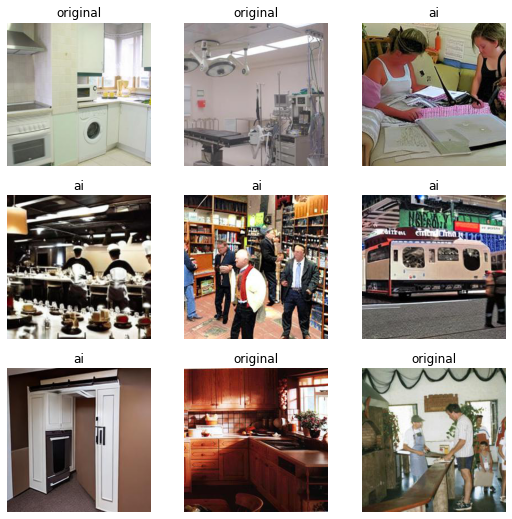

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter())

dls = dblock.dataloaders("dataset/stable_diffusion")
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229063,0.150657,0.940781,02:03


epoch,train_loss,valid_loss,accuracy,time
0,0.056933,0.042221,0.984315,02:40


In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.023628,0.048340,0.984155,02:04


epoch,train_loss,valid_loss,accuracy,time
0,0.033653,0.037384,0.988316,02:43


In [ ]:
models_path = Path("/content/drive/MyDrive/ Studies/Fall 2022/Computer Vision/Final Project/models")
torch.save(learn.state_dict(), models_path)

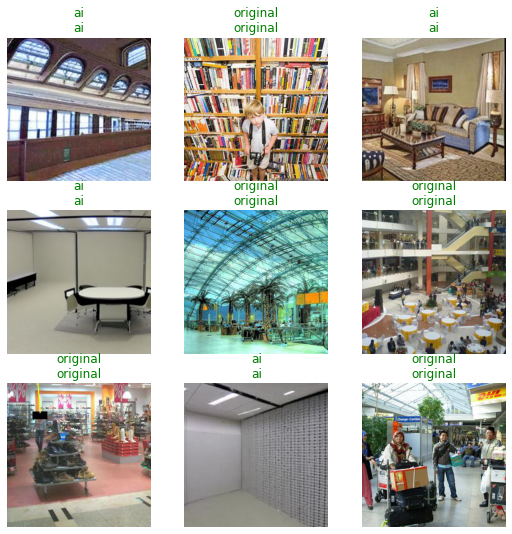

In [ ]:
learn.show_results()

In [ ]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

In [ ]:
dataset_image_paths = glob("/content/dataset/weather/**/*")

In [ ]:
dataset_total = 0
dataset_correct_prediction = 0
dataset_ai_as_original = 0
dataset_original_as_ai = 0
dataset_ai_as_ai = 0
dataset_original_as_original = 0

for image_path in progress_bar(dataset_image_paths):
  ground_truth = label_func(Path(image_path))
  result = learn.predict(image_path)
  prediction = result[0]
  dataset_total += 1
  if ground_truth == prediction:
    dataset_correct_prediction += 1
    if ground_truth == "original":
      dataset_original_as_original += 1
    else:
      dataset_ai_as_ai += 1
  else:
    if ground_truth == "original":
      dataset_original_as_ai += 1
    else:
      dataset_ai_as_original += 1
  

In [ ]:
print(f"Set ai as positive, original as negative")

tn = dataset_original_as_original/dataset_total
tp = dataset_ai_as_ai/dataset_total
fp = dataset_original_as_ai/dataset_total
fn = dataset_ai_as_original/dataset_total

recall = tp/(fn+tp)
precision = tp/(fp+tp)
f1_score = 2*recall*precision/(recall+precision)
acc = (tp+tn)/(tp+tn+fp+fn)

print(f"Accuracy: {dataset_correct_prediction}/{dataset_total} = {dataset_correct_prediction/dataset_total} = {acc}")
print(f"{dataset_original_as_original} original images correctly detected. TN is {tn}")
print(f"{dataset_ai_as_ai} ai images correctly detected. TP is {tp} ")
print(f"{dataset_original_as_ai} original images falsly detected as ai ones. FP is {fp} ")
print(f"{dataset_ai_as_original} ai images falsly detected as original ones. FN is {fn} ")
print(f"recall is {recall}, precision is {precision}, f1_score is {f1_score}")


Set ai as positive, original as negative
Accuracy: 12144/13474 = 0.9012913759833754 = 0.9012913759833754
6278 original images correctly detected. TN is 0.4659343921626837
5866 ai images correctly detected. TP is 0.4353569838206917 
459 original images falsly detected as ai ones. FP is 0.03406560783731631 
871 ai images falsly detected as original ones. FN is 0.0646430161793083 
recall is 0.8707139676413834, precision is 0.9274308300395256, f1_score is 0.8981779206859593
